# Projet Chaos

## Modules

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from scipy import optimize
from scipy.integrate import solve_ivp


plt.rcParams.update({"font.size":20, "font.family":'Times New Roman'})

## Fonctions

Basées sur les équations de l'article de Bindschadler et Sneyd, 2001.

In [151]:
# Définition des constantes utilisées
kf = 28 # uM/s
Vp = 1.2 # uM/s
R5 = 1.6 # uM
R3 = 50 # uM
r2 = 100 # 1/uMs
R1 = 6 # uM
leak = 0.2 # uM/s
Kp = 0.18 # uM
k2 = 26.5 # uM/s
k1 = 44 # uM/s 
r4 = 20 # 1/s
k3 = 1.6 # uM/s


# Fonctions de bases
def phi_1(conc):
    """
        Calcul du taux phi_1, en fonction de la concentration du calcium.
    Args :
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée
    """
    return (r2*conc)/(R1+conc), (r2*R1) / (R1+conc)**2

def phi_m1(conc):
    """
        Calcul du taux phi_-1, en fonction de la concentration du calcium.
    Args :
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée
    """
    return k1/(R3+conc), -k1 / (R3+conc)**2

def phi_2(conc):
    """
        Calcul du taux phi_2, en fonction de la concentration du calcium.
    Args :
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée
    """
    return (k2 + r4*conc)/(R3+conc), (R3*r4 - k2) / (R3+conc)**2

def phi_3(conc):
    """
        Calcul du taux phi_3, en fonction de la concentration du calcium.
    Args :
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée
    """
    return k3/(R5+conc), -k3 / (R5+conc)**2

def pump(conc):
    """
        Calcul du taux de calcium étant pompé dans la cellule.
    Args :
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée
    """
    return (Vp * conc**2)/(Kp**2 + conc**2), (2*Vp * Kp**2 * conc) / (Kp**2 + conc**2)**2

# Fonctions combinées
def recept(p, h, conc):
    """
        Calcul du taux de calcium qui entre dans la cellule par un récepteur InsP3 du réticulum endoplasmique.
    Args :
        p : Concentration d'InsP3
        h : Fraction des récepteurs ouverts ou fermés
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée p/r conc
        2 : Dérivée p/r h
    """
    paren = (p*h*phi_1(conc)[0]) / (phi_1(conc)[0]*p + phi_m1(conc)[0])
    fonc = kf * paren**4
    d_dc = 4 * kf * paren**3 * ((p*h * (phi_m1(conc)[0]*phi_1(conc)[1] - phi_1(conc)[0]*phi_m1(conc)[1])) / (phi_1(conc)[0]*p + phi_m1(conc)[0])**2)
    d_dh = 4 * kf * paren**3 * (p*phi_1(conc)[0]) / (phi_1(conc)[0]*p + phi_m1(conc)[0])
    return fonc, d_dc, d_dh

def InsP3(p, h, conc):
    """
        Équation différentielle d'ordre 1 décrivant la fraction de récepteurs InsP3 ouverts ou fermés.
    Args :
        p : Concentration d'InsP3
        h : Fraction des récepteurs ouverts ou fermés
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée p/r conc
        2 : Dérivée p/r h
    """
    fonc = phi_3(conc)[0]*(1-h) - ((phi_1(conc)[0]*phi_2(conc)[0]*h*p)/(phi_1(conc)[0]*p + phi_m1(conc)[0]))
    d_dc = phi_3(conc)[1]*(1-h) - ((h*p*(phi_m1(conc)[0]*phi_2(conc)[0]*phi_1(conc)[1] +
                                        (phi_1(conc)[0]**2)* phi_2(conc)[1]*p + phi_m1(conc)[0]*phi_1(conc)[0]*phi_2(conc)[1]
                                        - phi_1(conc)[0]*phi_2(conc)[0]*phi_m1(conc)[1])) / (phi_1(conc)[0]*p + phi_m1(conc)[0])**2)
    d_dh = - phi_3(conc)[0] - ((phi_1(conc)[0]*phi_2(conc)[0]*p) / (phi_1(conc)[0]*p + phi_m1(conc)[0]))
    return fonc, d_dc, d_dh

# Fonctions pour une seule cellule
def one_cell_conc(p, h, conc):
    """
        Équation différentielle d'ordre 1 décrivant la variation de concentration du calcium dans une seule cellule.
    Args :
        p : Concentration d'InsP3
        h : Fraction des récepteurs ouverts ou fermés
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée p/r conc
        2 : Dérivée p/r h
    """
    fonc = recept(p, h, conc)[0] - pump(conc)[0] + leak
    d_dc = recept(p, h, conc)[1] - pump(conc)[1]
    d_dh = recept(p, h, conc)[2]
    return fonc, d_dc, d_dh

def system_one_cell(t, y, p):
    """
        Système EDO d'ordre 1 décrivant la variation de concentration du calcium dans une seule cellule.
    Args :
        t : temps
        y : tuple (concentration, h)
        p : Concentration d'InsP3
    Returns :
        0 : Système
    """
    h, conc = y
    dc_dt = one_cell_conc(p, h, conc)[0]
    dh_dt = InsP3(p, h, conc)[0]
    return [dh_dt, dc_dt]

def points_fixes_one_cell(sol, p):
    '''
        Calcul des points fixes.
    Args : 
        Sol : Solution du système d'EDO.
        p : Concentration d'InsP3.
    Returns :
        Points fixes.
    '''
    t_values = np.linspace(*t_span, 1000)
    x_values, y_values = sol.sol(t_values)
    dx_dt_values, dy_dt_values = system_one_cell(t_values, [x_values, y_values], p)
    indices_points_fixes = np.where((np.abs(dx_dt_values) < 1e-6) & (np.abs(dy_dt_values) < 1e-6))
    return x_values[indices_points_fixes], y_values[indices_points_fixes]

def points_one_cell(sol, p):
    '''
        Calcul des points.
    Args : 
        Sol : Solution du système d'EDO.
        p : Concentration d'InsP3.
    Returns :
        Points (t, x, y).
    '''
    t_values = np.linspace(*t_span, 10000)
    x_values, y_values = sol.sol(t_values)
    # dx_dt_values, dy_dt_values = system(t_values, [x_values, y_values], p)
    return t_values, x_values, y_values

# Fonctions pour deux cellules
def diff_two_cells(D, conc1, conc2):
    """
        Calcul du taux de calcium étant pompé diffusé entre les deux .
    Args :
        D : Constante de proportionnalité, si 0 --> cellules sans interaction
        Conc1 : Concentration de calcium dans la cellule 1
        Conc2 : Concentration de calcium dans la cellule 2
    Returns :
        0 : Fonction
        1 : Dérivée p/r conc1
        2 : Dérivée p/r conc2
    """
    fonc =  D*(conc2-conc1)
    d_dc1 = D*conc2
    d_dc2 = -D*conc1
    return fonc, d_dc1, d_dc2

def two_cells_conc(p, h, conc1, conc2, D):
    """
        Équation différentielle d'ordre 1 décrivant la variation de concentration du calcium dans une seule cellule.
    Args :
        p : Concentration d'InsP3
        h : Fraction des récepteurs ouverts ou fermés 
        Conc1 : Concentration de calcium dans la cellule 1
        Conc2 : Concentration de calcium dans la cellule 2
        D : Constante de proportionnalité, si 0 --> cellules sans interaction
    Returns :
        0 : Fonction
        1 : Dérivée p/r conc1
        2 : Dérivée p/r h
        3 : Dérivée p/r conc2
    """
    fonc = recept(p, h, conc1)[0] - pump(conc1)[0] + leak + diff_two_cells(D, conc1, conc2)[0]
    d_dc1 = recept(p, h, conc1)[1] - pump(conc1)[1] + diff_two_cells(D, conc1, conc2)[1]
    d_dh = recept(p, h, conc1)[2]
    d_dc2 = diff_two_cells(D, conc1, conc2)[2]
    return fonc, d_dc1, d_dh, d_dc2

def system_two_cell(t, y, p):
    """
        Système EDO d'ordre 1 décrivant la variation de concentration du calcium dans une seule cellule.
    Args :
        t : temps
        y : tuple (concentration1, h1, concentration2, h2)
        p : Concentration d'InsP3
    Returns :
        0 : Système
    """
    h1, conc1, h2, conc2 = y
    dc_dt1 = two_cells_conc(p, h1, conc1, conc2, D)[0]
    dh_dt1 = InsP3(p, h1, conc1)[0]
    dc_dt2 = two_cells_conc(p, h2, conc2, conc1, D)[0]
    dh_dt2 = InsP3(p, h2, conc2)[0]
    return [dh_dt1, dc_dt1, dh_dt2, dc_dt2]

def points_fixes_two_cell(sol, p):
    '''
        Calcul des points fixes.
    Args : 
        Sol : Solution du système d'EDO.
        p : Concentration d'InsP3.
    Returns :
        Points fixes.
    '''
    t_values = np.linspace(*t_span, 1000)
    x1_values, y1_values, x2_values, y2_values = sol.sol(t_values)
    dx_dt1_values, dy_dt1_values, dx_dt2_values, dy_dt2_values = system_two_cell(t_values, [x1_values, y1_values, x2_values, y2_values], p)
    indices_points_fixes1 = np.where((np.abs(dx_dt1_values) < 1e-6) & (np.abs(dy_dt1_values) < 1e-6))
    indices_points_fixes2 = np.where((np.abs(dx_dt2_values) < 1e-6) & (np.abs(dy_dt2_values) < 1e-6))
    return x1_values[indices_points_fixes1], y1_values[indices_points_fixes1], x2_values[indices_points_fixes2], y2_values[indices_points_fixes2]

def points_two_cell(sol):
    '''
        Calcul des points.
    Args : 
        Sol : Solution du système d'EDO.
        p : Concentration d'InsP3.
    Returns :
        Points (temps, h1, conc1, h2, conc2)
    '''
    t_values = np.linspace(*t_span, 10000)
    x1_values, y1_values, x2_values, y2_values = sol.sol(t_values)
    # dx_dt1_values, dy_dt1_values, dx_dt2_values, dy_dt2_values = system_two_cell(t_values, [x1_values, y1_values, x2_values, y2_values], p)
    return t_values, x1_values, y1_values, x2_values, y2_values

## Une cellule

Modifier les conditions initiales pour vérifier les résultats. Conditions initiales --> lignes 2, valeurs de p --> ligne 13.


Résultats :

Points fixes trouvés :
h = 0.9270905721589948, conc = 0.08206279298903103
h = 0.9270906139903835, conc = 0.08206291980980494


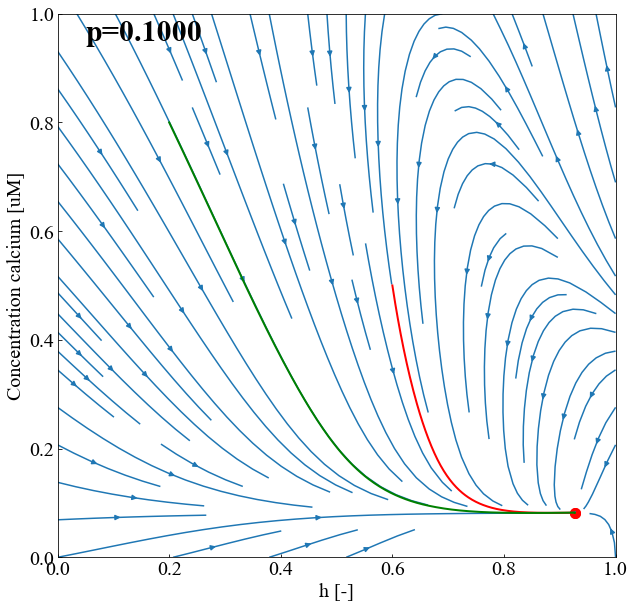

Points fixes trouvés :
h = 0.8173975291209892, conc = 0.12791909184055367


Points fixes trouvés :


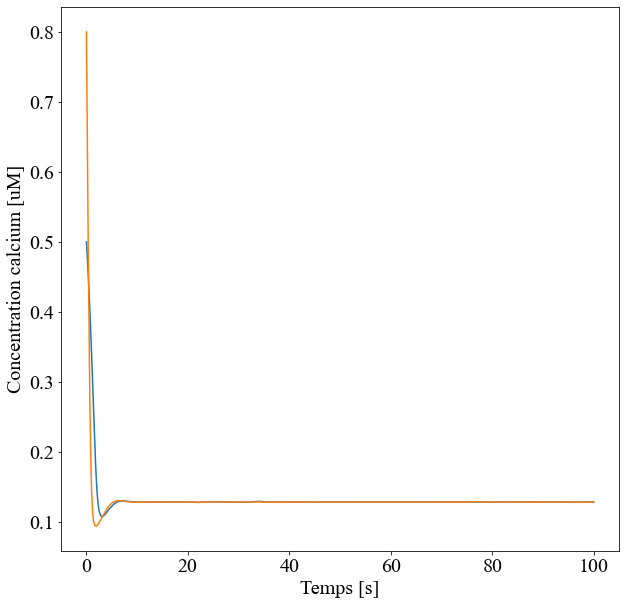

Points fixes trouvés :


In [152]:
# Résolution problème aux valeurs initiales
initial_conditions1 = [0.6, 0.5]  # Conditions initiales [# porte ouverte/fermée, conc Ca]
initial_conditions2 = [0.2, 0.8]
t_span = [0, 100]  # Plage de temps

# Limites du portrait de phase
xmax, ymax = 1, 1

# Meshgrid
h, conc = np.meshgrid(np.linspace(0,xmax,400), np.linspace(0,ymax,400))

# Figures pour différentes valeurs de p
for p in [0.1, 0.2333, 0.2733, 0.2756]: # np.linspace(0.2, 0.25, 10):

    # Équations différentielles
    dc_dt, dh_dt = one_cell_conc(p, h, conc)[0], InsP3(p, h, conc)[0]

    # Trajectoire 1
    sol = solve_ivp(system_one_cell, t_span, initial_conditions1, dense_output=True, args=[p])
    h_fixes, conc_fixes = points_fixes_one_cell(sol, p)
    temps, h_val, conc_val = points_one_cell(sol, p)

    # Trajectoire 2
    sol2 = solve_ivp(system_one_cell, t_span, initial_conditions2, dense_output=True, args=[p])
    h_fixes2, conc_fixes2 = points_fixes_one_cell(sol2, p)
    temps2, h_val2, conc_val2 = points_one_cell(sol2, p)

    print("Points fixes trouvés :")
    fig1, ax = plt.subplots(1, 1, figsize=(10,10))
    for h_fix, conc_fix in zip(h_fixes, conc_fixes):
        print(f"h = {h_fix}, conc = {conc_fix}")
        ax.scatter(h_fix, conc_fix, color="red", s=100)

    # Portrait de phases
    ax.set_xlabel('h [-]')
    ax.set_ylabel('Concentration calcium [uM]')
    ax.set_xlim(0,xmax)
    ax.set_ylim(0,ymax)
    ax.streamplot(h, conc, dh_dt, dc_dt)
    ax.tick_params(direction="in")
    ax.plot(h_val, conc_val, color="red", lw=2)
    ax.plot(h_val2, conc_val2, color="green", lw=2)
    ax.text(0.05, 0.95, f"p={p:.4f}", fontweight='bold', fontsize=30)
    plt.show()

    # Concentration en fonction du temps
    fig2 = plt.figure(figsize=(10,10))
    plt.plot(temps, conc_val)
    plt.plot(temps2, conc_val2)
    plt.xlabel('Temps [s]')
    plt.ylabel('Concentration calcium [uM]')

## Deux cellules

Modifier les conditions initiales pour vérifier les résultats. Conditions initiales --> lignes 2, valeur de D --> ligne 14, valeurs de p --> ligne 15.


Résultats :


* Selon les conditions frontières ça plante ou non...

Points fixes trouvés, graph1 :
h1 = 0.9270906031702163, conc1 = 0.08206292505069045
h1 = 0.9270905795426653, conc1 = 0.08206281608145588
Points fixes trouvés, graph2 :
h2 = 0.9270903723693456, conc2 = 0.08206246618150184
h2 = 0.9270905199975237, conc2 = 0.08206266445306708
h2 = 0.927090458875423, conc2 = 0.08206250461882178
h2 = 0.9270905221527417, conc2 = 0.08206258523115731


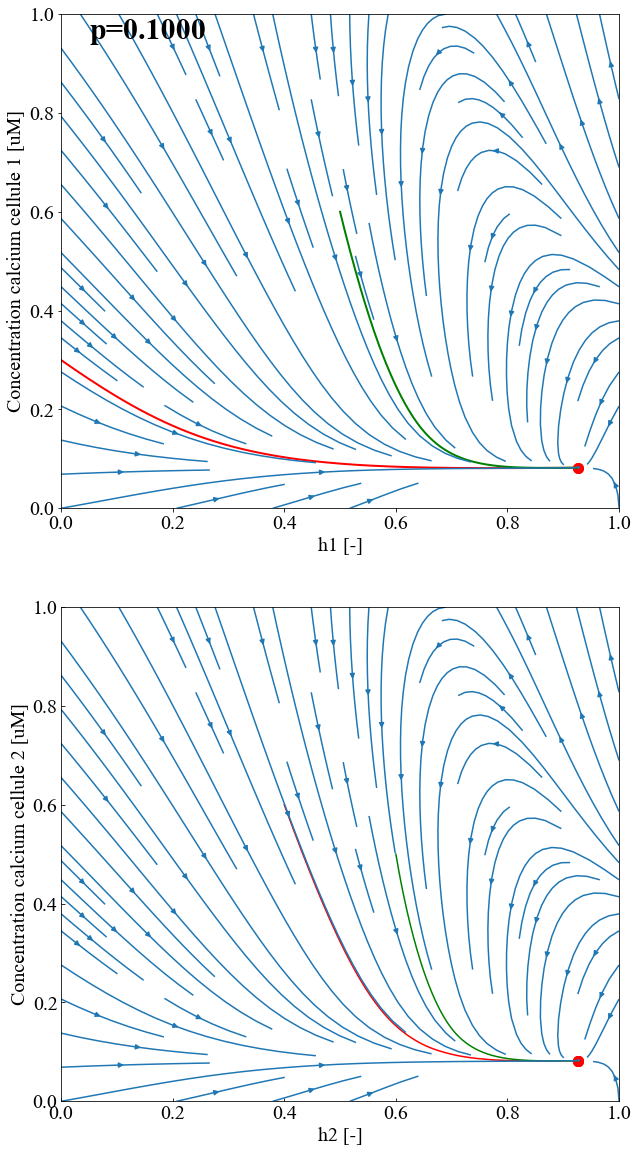

Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


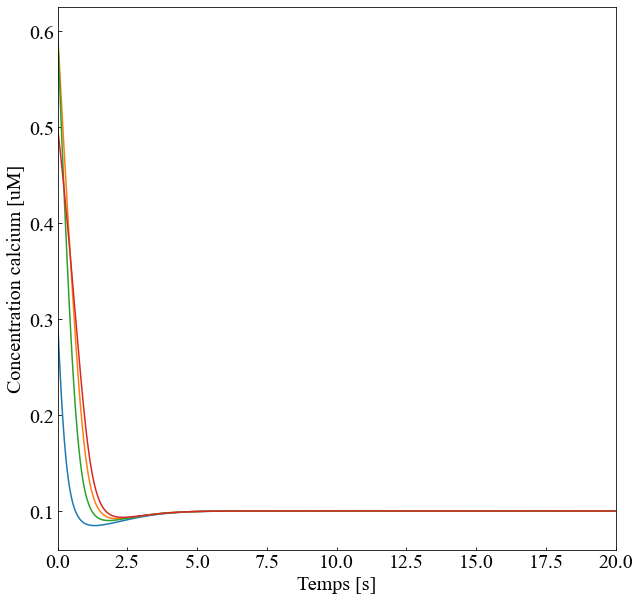

Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


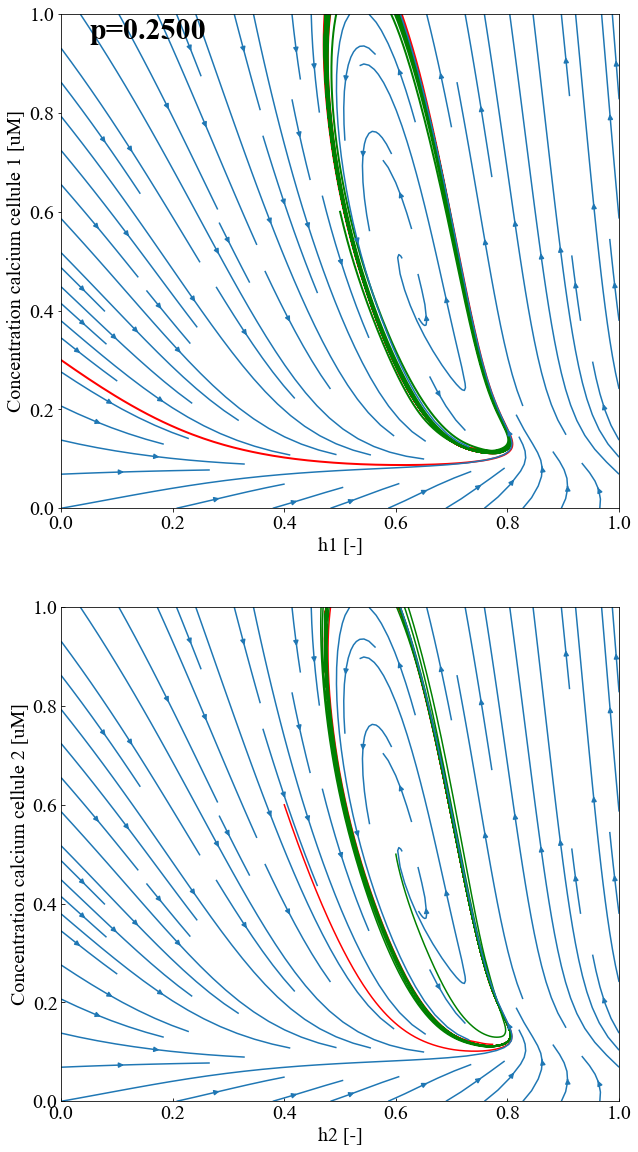

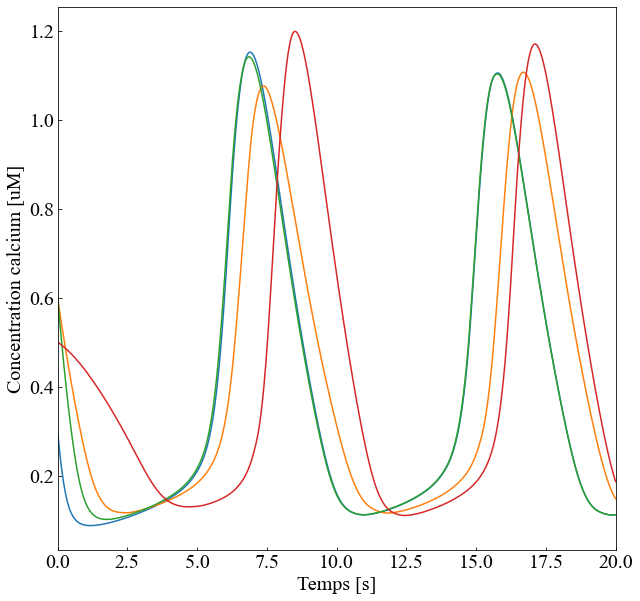

Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


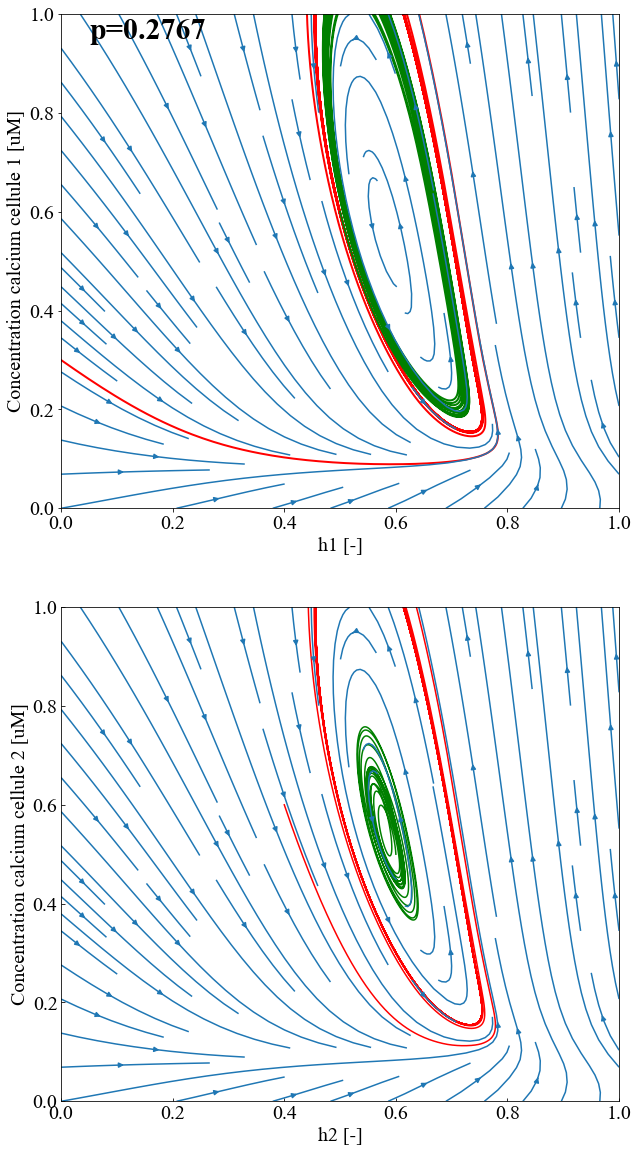

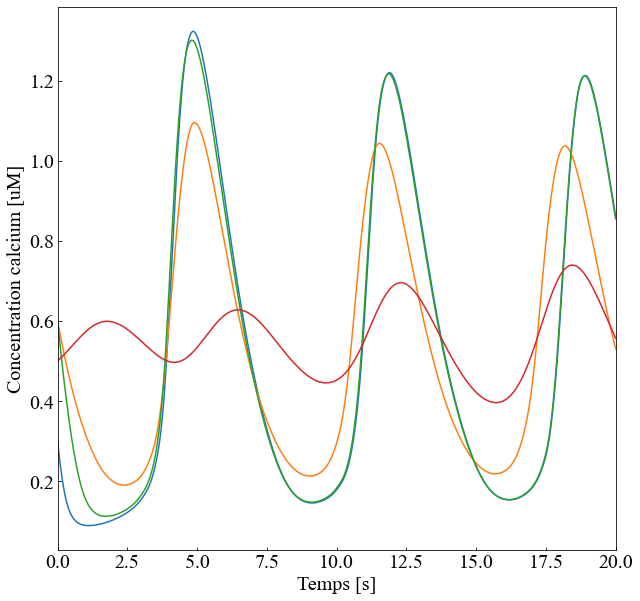

Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


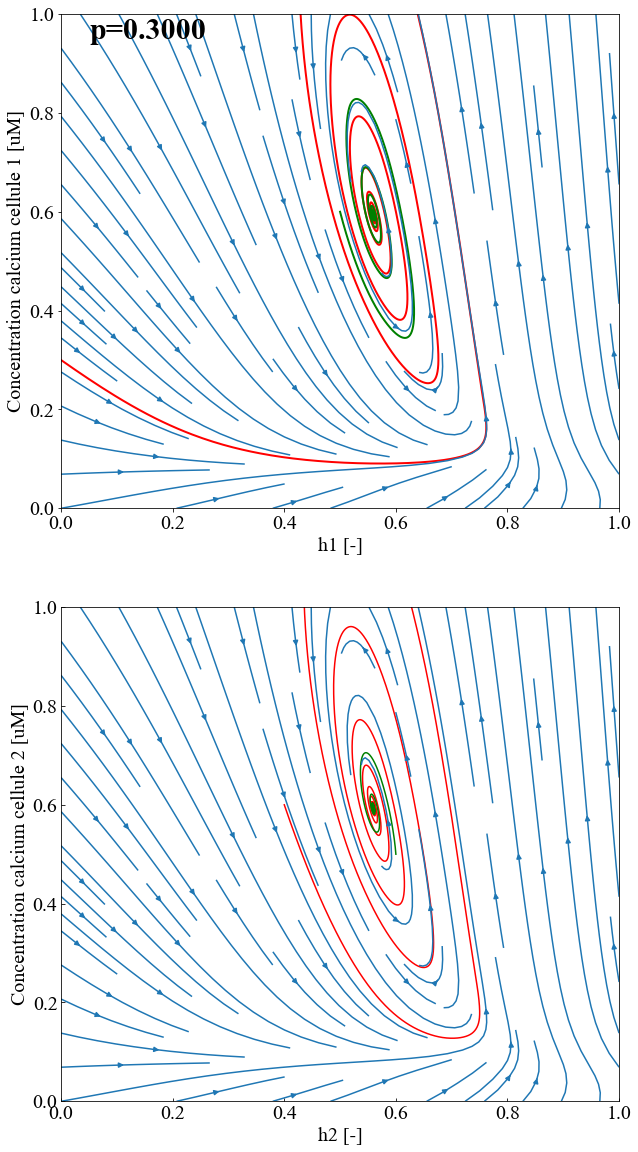

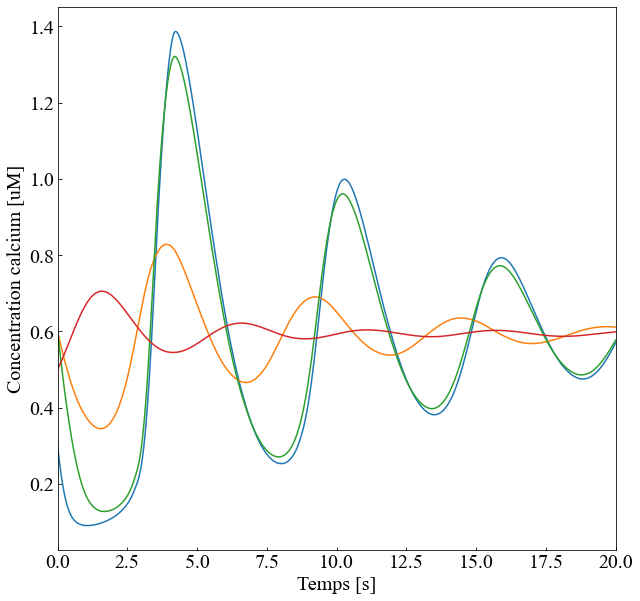

In [163]:
# Résolution problème aux valeurs initiales
initial_conditions1 = [0, 0.3, 0.4, 0.6]  # Conditions initiales [# porte ouverte/fermée, conc Ca] 
initial_conditions2 = [0.5, 0.6, 0.6, 0.5]
t_span = [0, 100]  # Plage de temps

# Limites du portrait de phase
xmax, ymax = 1, 1

# Meshgrid
h1, conc1 = np.meshgrid(np.linspace(0,xmax,400), np.linspace(0,ymax,400))
h2, conc2 = np.meshgrid(np.linspace(0,xmax,400), np.linspace(0,ymax,400))

# Figures pour différentes valeurs de p
D = 0.05
for p in [0.1, 0.2, 0.25, 0.2767, 0.3]: # np.linspace(0.23,0.29,10):

    # Équations différentielles
    dc_dt1, dh_dt1 = two_cells_conc(p, h1, conc1, conc2, D)[0], InsP3(p, h1, conc1)[0]
    dc_dt2, dh_dt2 = two_cells_conc(p, h2, conc2, conc1, D)[0], InsP3(p, h2, conc2)[0]

    # Trajectoire 1
    sol = solve_ivp(system_two_cell, t_span, initial_conditions1, dense_output=True, args=[p])
    h1_fixes, conc1_fixes, h2_fixes, conc2_fixes = points_fixes_two_cell(sol, p)
    temps, h1_val, conc1_val, h2_val, conc2_val = points_two_cell(sol)

    # Trajectoire 2
    sol2 = solve_ivp(system_two_cell, t_span, initial_conditions2, dense_output=True, args=[p])
    h1_fixes2, conc1_fixes2, h2_fixes2, conc2_fixes2 = points_fixes_two_cell(sol2, p)
    temps2, h1_val2, conc1_val2, h2_val2, conc2_val2 = points_two_cell(sol2)

    print("Points fixes trouvés, graph1 :")
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,20))
    for h1_fix, conc1_fix in zip(h1_fixes, conc1_fixes):
        print(f"h1 = {h1_fix}, conc1 = {conc1_fix}")
        ax1.scatter(h1_fix, conc1_fix, color="red", s=100)
    print("Points fixes trouvés, graph2 :")
    for h2_fix, conc2_fix in zip(h2_fixes, conc2_fixes):
        print(f"h2 = {h2_fix}, conc2 = {conc2_fix}")
        ax2.scatter(h2_fix, conc2_fix, color="red", s=100)

    # Portrait de phase
    ax1.set_xlabel('h1 [-]')
    ax1.set_ylabel('Concentration calcium cellule 1 [uM]')
    ax1.set_xlim(0,xmax)
    ax1.set_ylim(0,ymax)
    ax2.set_xlim(0,xmax)
    ax2.set_ylim(0,ymax)
    ax1.plot(h1_val, conc1_val, color="red", lw=2)
    ax1.plot(h1_val2, conc1_val2, color="green", lw=2)
    ax1.streamplot(h1,conc1,dh_dt1,dc_dt1)
    plt.tick_params(direction="in")
    ax1.text(0.05, 0.95, f"p={p:.4f}", fontweight='bold', fontsize=30)
    ax2.set_xlabel('h2 [-]')
    ax2.set_ylabel('Concentration calcium cellule 2 [uM]')
    ax2.plot(h2_val, conc2_val, color="red")
    ax2.plot(h2_val2, conc2_val2, color="green")
    ax2.streamplot(h2,conc2,dh_dt2,dc_dt2)
    plt.show()

    # Concentration en fonction du temps
    fig = plt.figure(figsize=(10,10))
    plt.xlabel('Temps [s]')
    plt.ylabel('Concentration calcium [uM]')
    plt.plot(temps, conc1_val)
    plt.plot(temps2, conc1_val2)
    plt.xlim(0,20)
    plt.tick_params(direction="in")
    ax1.text(0.05, 0.2, f"p={p:.2f}", fontweight='bold', fontsize=30)
    plt.plot(temps, conc2_val)
    plt.plot(temps2, conc2_val2)
    plt.show()

C'est wack...

Points fixes trouvés, graph1 :
conc1 = 0.08206282832188246, conc2 = 0.08206245790205055
conc1 = 0.08206281763841221, conc2 = 0.08206257451613426
Points fixes trouvés, graph2 :
h1 = 0.927090554130254, h2 = 0.9270904709581489
h1 = 0.9270905525413542, h2 = 0.927090498595787


Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


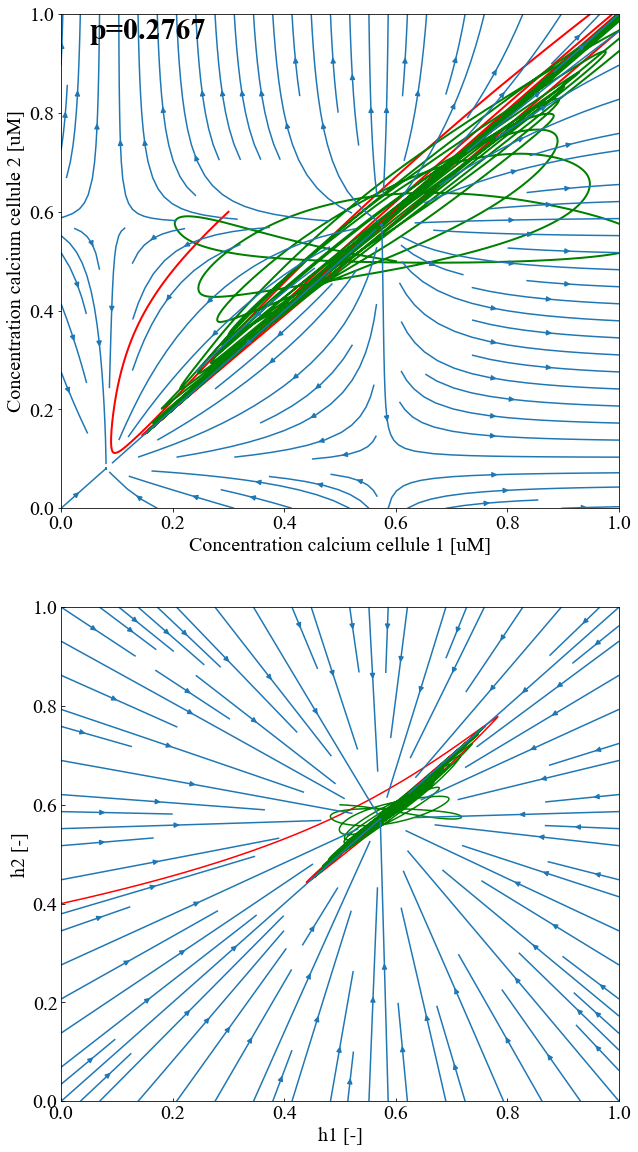

Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


In [164]:
# Résolution problème aux valeurs initiales
initial_conditions1 = [0, 0.3, 0.4, 0.6]  # Conditions initiales [# porte ouverte/fermée, conc Ca] 
initial_conditions2 = [0.5, 0.6, 0.6, 0.5]
t_span = [0, 100]  # Plage de temps

# Limites du portrait de phase
xmax, ymax = 1, 1

# Meshgrid
conc1, conc2 = np.meshgrid(np.linspace(0,xmax,400), np.linspace(0,ymax,400))
h1, h2 = np.meshgrid(np.linspace(0,xmax,400), np.linspace(0,ymax,400))

# Figures pour différentes valeurs de p
D = 0.07
for p in [0.1, 0.2, 0.25, 0.2767, 0.3]: # np.linspace(0.23,0.29,10):

    # Équations différentielles
    dc_dt1, dh_dt1 = two_cells_conc(p, h1, conc1, conc2, D)[0], InsP3(p, h1, conc1)[0]
    dc_dt2, dh_dt2 = two_cells_conc(p, h2, conc2, conc1, D)[0], InsP3(p, h2, conc2)[0]

    # Trajectoire 1
    sol = solve_ivp(system_two_cell, t_span, initial_conditions1, dense_output=True, args=[p])
    h1_fixes, conc1_fixes, h2_fixes, conc2_fixes = points_fixes_two_cell(sol, p)
    temps, h1_val, conc1_val, h2_val, conc2_val = points_two_cell(sol)

    # Trajectoire 2
    sol2 = solve_ivp(system_two_cell, t_span, initial_conditions2, dense_output=True, args=[p])
    h1_fixes2, conc1_fixes2, h2_fixes2, conc2_fixes2 = points_fixes_two_cell(sol2, p)
    temps2, h1_val2, conc1_val2, h2_val2, conc2_val2 = points_two_cell(sol2)

    print("Points fixes trouvés, graph1 :")
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,20))
    for conc1_fix, conc2_fix in zip(conc1_fixes, conc2_fixes):
        print(f"conc1 = {conc1_fix}, conc2 = {conc2_fix}")
        ax1.scatter(conc1_fix, conc2_fix, color="red", s=100)
    print("Points fixes trouvés, graph2 :")
    for h1_fix, h2_fix in zip(h1_fixes, h2_fixes):
        print(f"h1 = {h1_fix}, h2 = {h2_fix}")
        ax2.scatter(h1_fix, h2_fix, color="red", s=100)

    # Portrait de phase
    ax1.set_xlabel('Concentration calcium cellule 1 [uM]')
    ax1.set_ylabel('Concentration calcium cellule 2 [uM]')
    ax1.set_xlim(0,xmax)
    ax1.set_ylim(0,ymax)
    ax2.set_xlim(0,xmax)
    ax2.set_ylim(0,ymax)
    ax1.plot(conc1_val, conc2_val, color="red", lw=2)
    ax1.plot(conc1_val2, conc2_val2, color="green", lw=2)
    ax1.streamplot(conc1,conc2,dc_dt1,dc_dt2)
    plt.tick_params(direction="in")
    ax1.text(0.05, 0.95, f"p={p:.4f}", fontweight='bold', fontsize=30)
    ax2.set_xlabel('h1 [-]')
    ax2.set_ylabel('h2 [-]')
    ax2.plot(h1_val, h2_val, color="red")
    ax2.plot(h1_val2, h2_val2, color="green")
    ax2.streamplot(h1,h2,dh_dt1,dh_dt2)
    plt.show()

## Trois cellules

## Deux cellules différentes

In [165]:
# Fonctions combinées
def recept(p, h, conc, kf):
    """
        Calcul du taux de calcium qui entre dans la cellule par un récepteur InsP3 du réticulum endoplasmique.
    Args :
        p : Concentration d'InsP3
        h : Fraction des récepteurs ouverts ou fermés
        Conc : Concentration de calcium
    Returns :
        0 : Fonction
        1 : Dérivée p/r conc
        2 : Dérivée p/r h
    """
    paren = (p*h*phi_1(conc)[0]) / (phi_1(conc)[0]*p + phi_m1(conc)[0])
    fonc = kf * paren**4
    d_dc = 4 * kf * paren**3 * ((p*h * (phi_m1(conc)[0]*phi_1(conc)[1] - phi_1(conc)[0]*phi_m1(conc)[1])) / (phi_1(conc)[0]*p + phi_m1(conc)[0])**2)
    d_dh = 4 * kf * paren**3 * (p*phi_1(conc)[0]) / (phi_1(conc)[0]*p + phi_m1(conc)[0])
    return fonc, d_dc, d_dh

# Nouvelles fonctions pour deux cellules
def two_cells_conc(p, h, conc1, conc2, D, kf):
    """
        Équation différentielle d'ordre 1 décrivant la variation de concentration du calcium dans une seule cellule.
    Args :
        p : Concentration d'InsP3
        h : Fraction des récepteurs ouverts ou fermés 
        Conc1 : Concentration de calcium dans la cellule 1
        Conc2 : Concentration de calcium dans la cellule 2
        D : Constante de proportionnalité, si 0 --> cellules sans interaction
    Returns :
        0 : Fonction
        1 : Dérivée p/r conc1
        2 : Dérivée p/r h
        3 : Dérivée p/r conc2
    """
    fonc = recept(p, h, conc1, kf)[0] - pump(conc1)[0] + leak + diff_two_cells(D, conc1, conc2)[0]
    d_dc1 = recept(p, h, conc1, kf)[1] - pump(conc1)[1] + diff_two_cells(D, conc1, conc2)[1]
    d_dh = recept(p, h, conc1, kf)[2]
    d_dc2 = diff_two_cells(D, conc1, conc2)[2]
    return fonc, d_dc1, d_dh, d_dc2

def system_two_cell(t, y, p, kf1, kf2):
    """
        Système EDO d'ordre 1 décrivant la variation de concentration du calcium dans une seule cellule.
    Args :
        t : temps
        y : tuple (concentration1, h1, concentration2, h2)
        p : Concentration d'InsP3
    Returns :
        0 : Système
    """
    h1, conc1, h2, conc2 = y
    dc_dt1 = two_cells_conc(p, h1, conc1, conc2, D, kf1)[0]
    dh_dt1 = InsP3(p, h1, conc1)[0]
    dc_dt2 = two_cells_conc(p, h2, conc2, conc1, D, kf2)[0]
    dh_dt2 = InsP3(p, h2, conc2)[0]
    return [dh_dt1, dc_dt1, dh_dt2, dc_dt2]

def points_fixes_two_cell(sol, p, kf1, kf2):
    '''
        Calcul des points fixes.
    Args : 
        Sol : Solution du système d'EDO.
        p : Concentration d'InsP3.
    Returns :
        Points fixes.
    '''
    t_values = np.linspace(*t_span, 1000)
    x1_values, y1_values, x2_values, y2_values = sol.sol(t_values)
    dx_dt1_values, dy_dt1_values, dx_dt2_values, dy_dt2_values = system_two_cell(t_values, [x1_values, y1_values, x2_values, y2_values], p, kf1, kf2)
    indices_points_fixes1 = np.where((np.abs(dx_dt1_values) < 1e-6) & (np.abs(dy_dt1_values) < 1e-6))
    indices_points_fixes2 = np.where((np.abs(dx_dt2_values) < 1e-6) & (np.abs(dy_dt2_values) < 1e-6))
    return x1_values[indices_points_fixes1], y1_values[indices_points_fixes1], x2_values[indices_points_fixes2], y2_values[indices_points_fixes2]

def points_two_cell(sol):
    '''
        Calcul des points.
    Args : 
        Sol : Solution du système d'EDO.
        p : Concentration d'InsP3.
    Returns :
        Points (temps, h1, conc1, h2, conc2)
    '''
    t_values = np.linspace(*t_span, 10000)
    x1_values, y1_values, x2_values, y2_values = sol.sol(t_values)
    # dx_dt1_values, dy_dt1_values, dx_dt2_values, dy_dt2_values = system_two_cell(t_values, [x1_values, y1_values, x2_values, y2_values], p)
    return t_values, x1_values, y1_values, x2_values, y2_values

Points fixes trouvés, graph1 :
x = 0.9270911121892157, y = 0.08206198914061492
x = 0.9270910945429329, y = 0.08206203256749141
Points fixes trouvés, graph2 :
x = 0.92713676575562, y = 0.08200426780307941
x = 0.9271367851864184, y = 0.08200447421985085


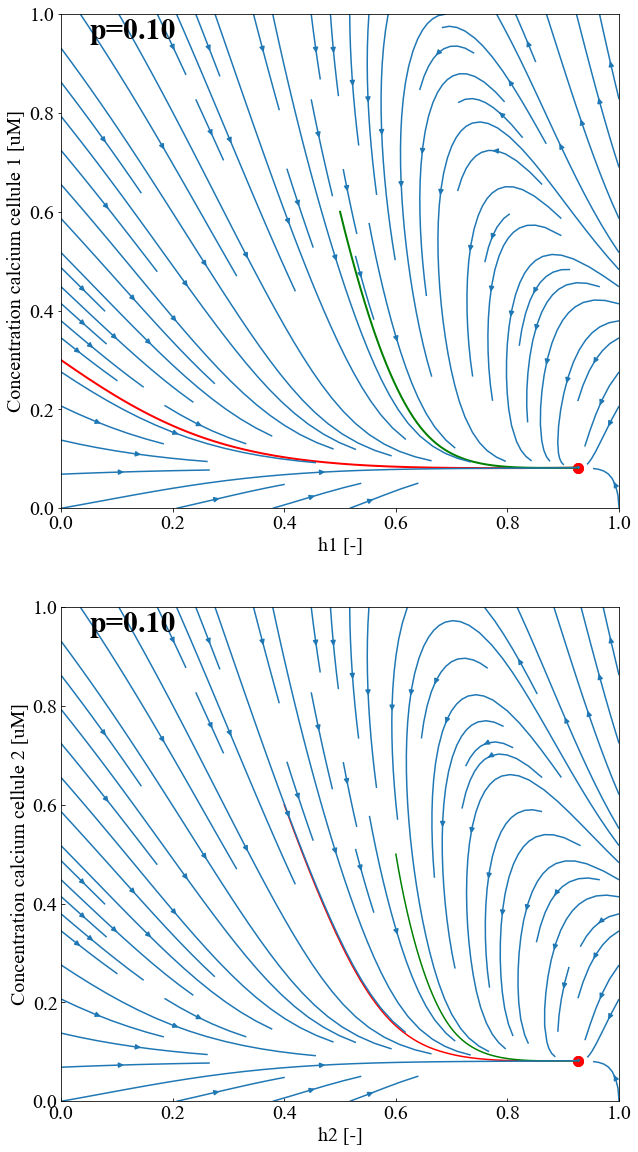

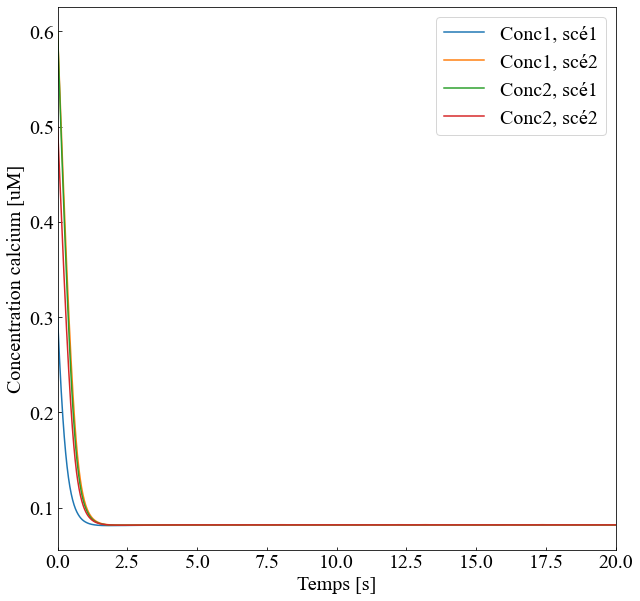

Points fixes trouvés, graph1 :
x = 0.895727846636612, y = 0.08682715691245765
x = 0.8957276806429915, y = 0.08682683911709671
x = 0.8957276350324869, y = 0.08682671740300434
Points fixes trouvés, graph2 :
x = 0.8959908742408789, y = 0.08655706553678058
x = 0.8959907879591793, y = 0.08655670046331998
x = 0.8959908962579213, y = 0.08655697353915788
x = 0.8959908755926532, y = 0.08655690070387712


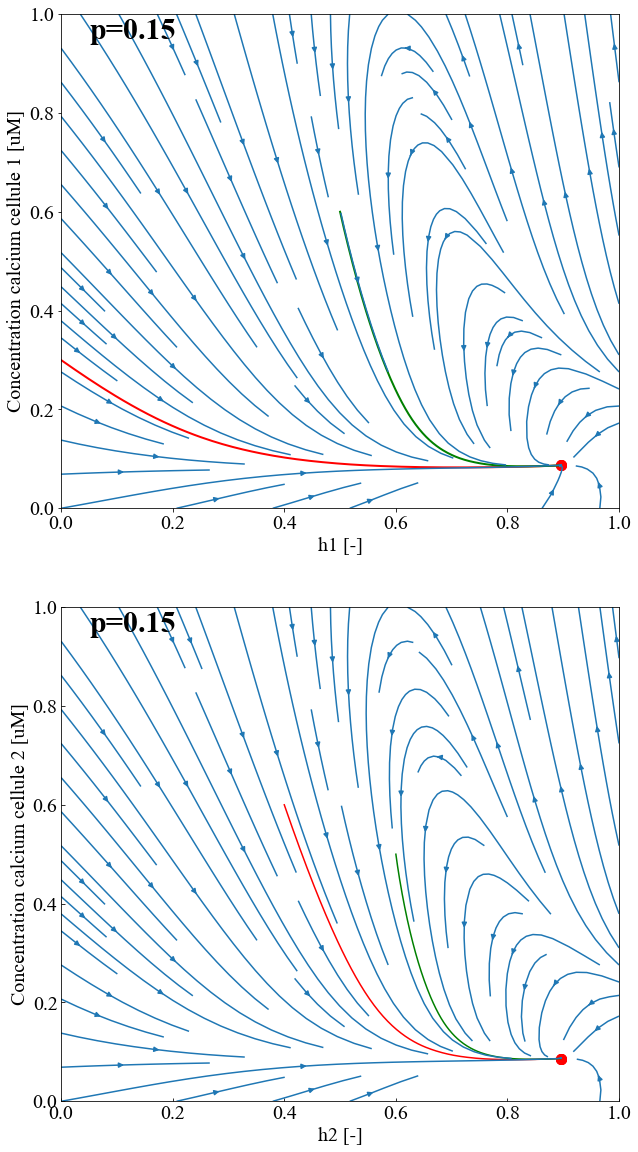

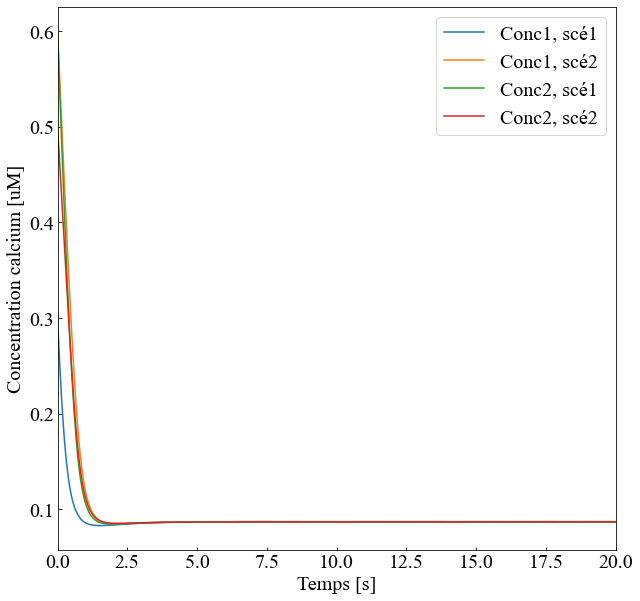

Points fixes trouvés, graph1 :
x = 0.8588269178334378, y = 0.10005408680482651
x = 0.858826774200353, y = 0.10005412989782357
Points fixes trouvés, graph2 :


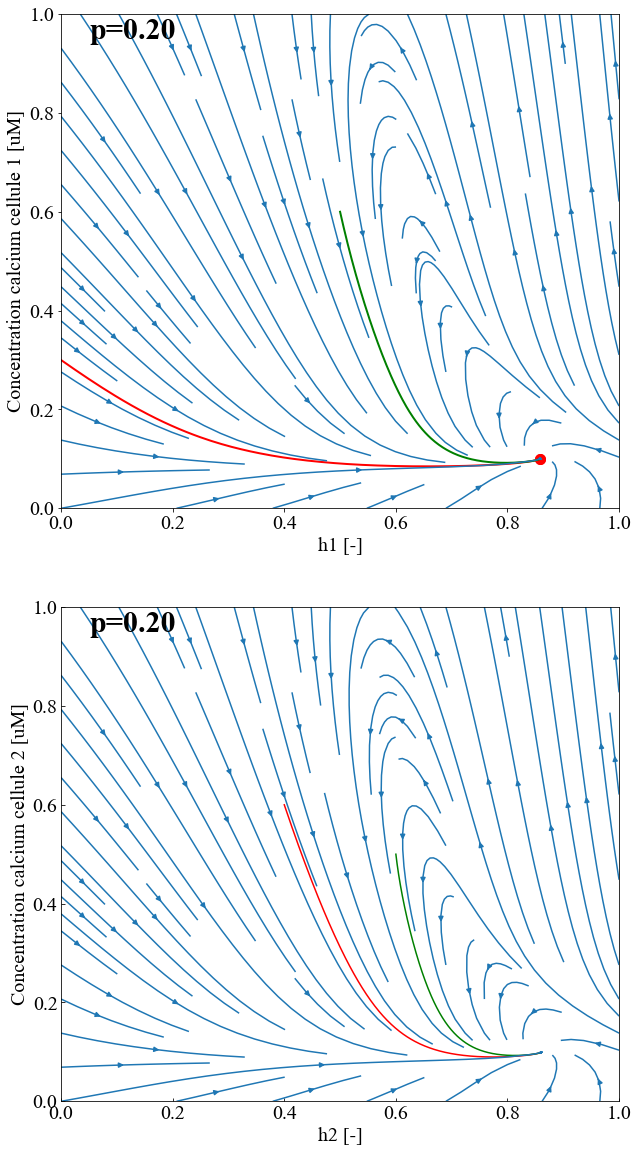

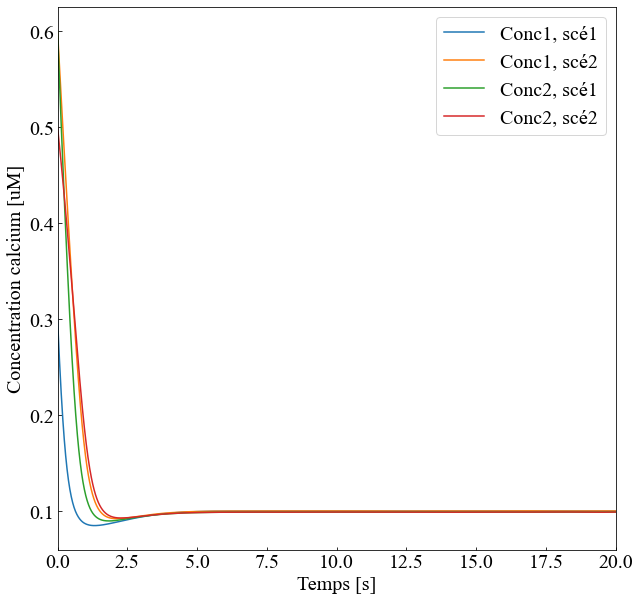

Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


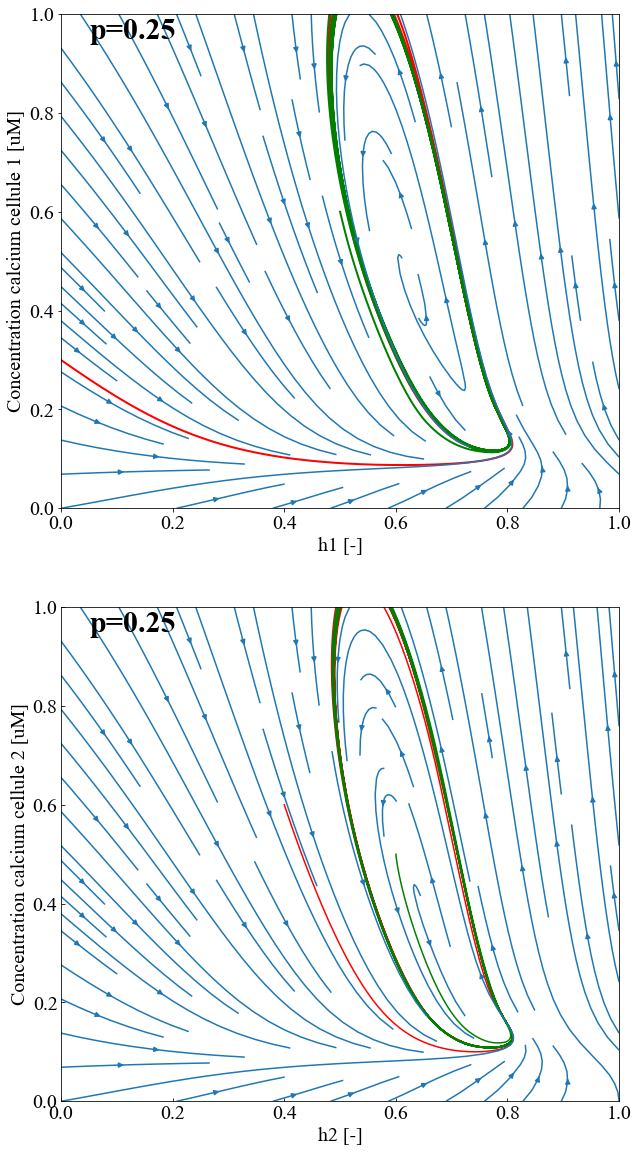

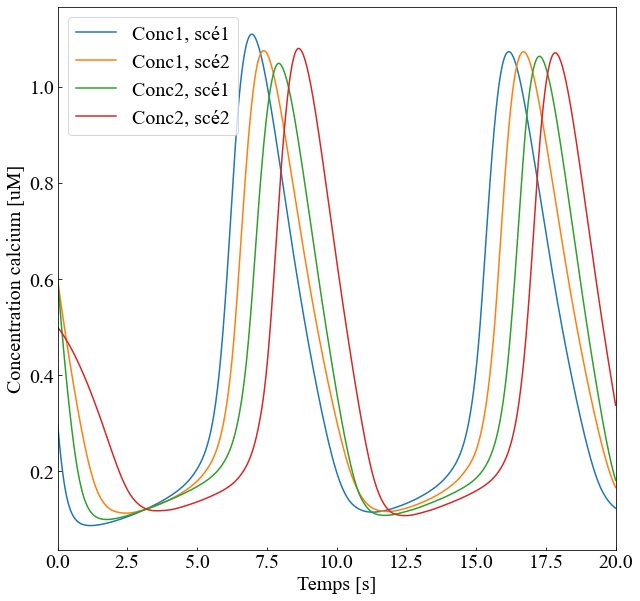

Points fixes trouvés, graph1 :
Points fixes trouvés, graph2 :


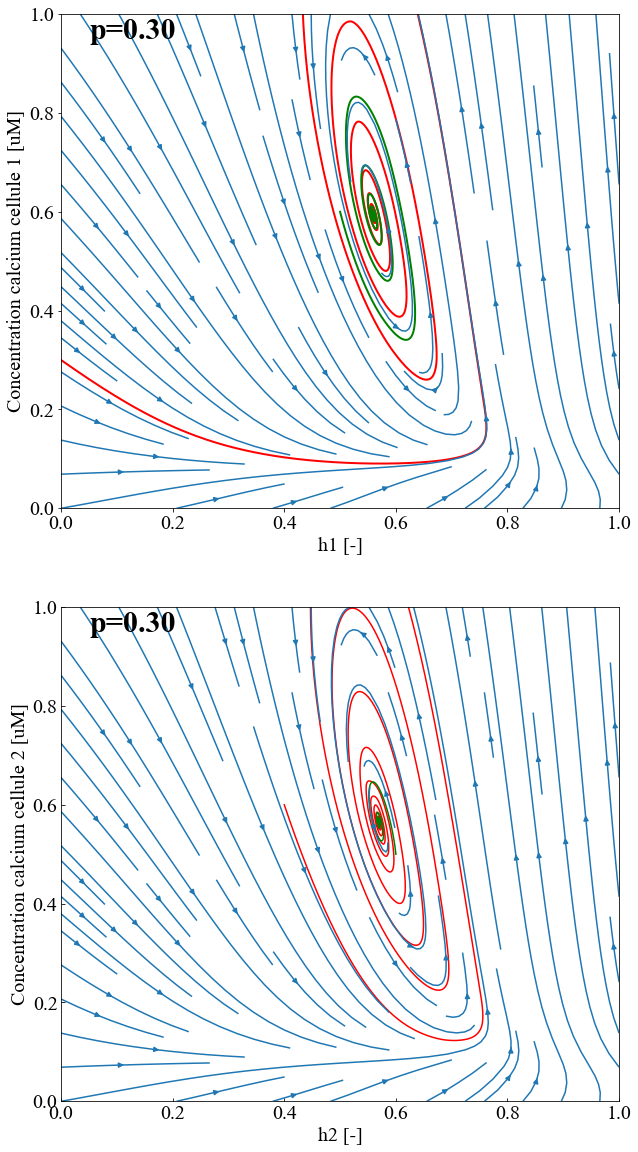

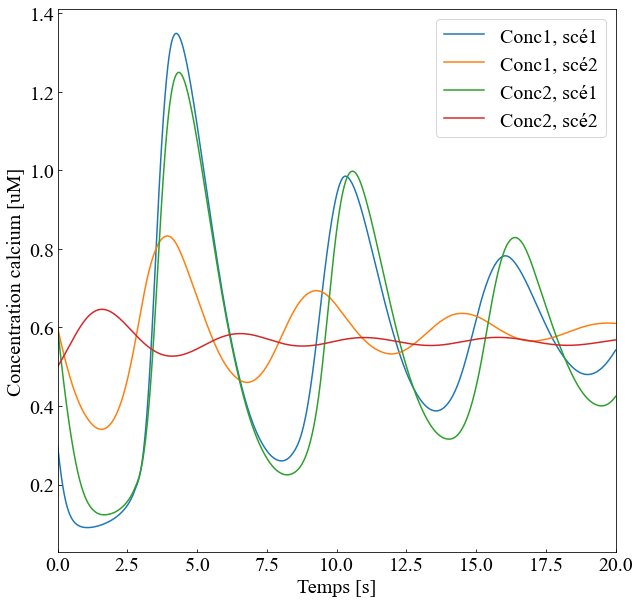

In [172]:
# Résolution problème aux valeurs initiales
initial_conditions1 = [0, 0.3, 0.4, 0.6]  # Conditions initiales [# porte ouverte/fermée, conc Ca] 
initial_conditions2 = [0.5, 0.6, 0.6, 0.5]
t_span = [0, 100]  # Plage de temps
kf1 = 28
kf2 = 27

# Limite du portrait de phase
xmax, ymax = 1, 1

# Meshgrid
h1, conc1 = np.meshgrid(np.linspace(0,xmax,400), np.linspace(0,ymax,400))
h2, conc2 = np.meshgrid(np.linspace(0,xmax,400), np.linspace(0,ymax,400))

# Figures pour différentes valeurs de p
D = 0.05
for p in np.linspace(0.1,0.3,5):
    
    # Équations différentielles
    dc_dt1, dh_dt1 = two_cells_conc(p, h1, conc1, conc2, D, kf1)[0], InsP3(p, h1, conc1)[0]
    dc_dt2, dh_dt2 = two_cells_conc(p, h2, conc2, conc1, D, kf2)[0], InsP3(p, h2, conc2)[0]

    # Trajectoire 1
    sol = solve_ivp(system_two_cell, t_span, initial_conditions1, dense_output=True, args=[p, kf1, kf2])
    h1_fixes, conc1_fixes, h2_fixes, conc2_fixes = points_fixes_two_cell(sol, p, kf1, kf2)
    temps, h1_val, conc1_val, h2_val, conc2_val = points_two_cell(sol)

    # Trajectoire 2
    sol2 = solve_ivp(system_two_cell, t_span, initial_conditions2, dense_output=True, args=[p, kf1, kf2])
    h1_fixes2, conc1_fixes2, h2_fixes2, conc2_fixes2 = points_fixes_two_cell(sol2, p, kf1, kf2)
    temps2, h1_val2, conc1_val2, h2_val2, conc2_val2 = points_two_cell(sol2)

    print("Points fixes trouvés, graph1 :")
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,20))
    for h1_fix, conc1_fix in zip(h1_fixes, conc1_fixes):
        print(f"x = {h1_fix}, y = {conc1_fix}")
        ax1.scatter(h1_fix, conc1_fix, color="red", s=100)
    print("Points fixes trouvés, graph2 :")
    for h2_fix, conc2_fix in zip(h2_fixes, conc2_fixes):
        print(f"x = {h2_fix}, y = {conc2_fix}")
        ax2.scatter(h2_fix, conc2_fix, color="red", s=100)

    # Portrait de phase
    ax1.set_xlabel('h1 [-]')
    ax1.set_ylabel('Concentration calcium cellule 1 [uM]')
    ax1.set_xlim(0,xmax)
    ax1.set_ylim(0,ymax)
    ax2.set_xlim(0,xmax)
    ax2.set_ylim(0,ymax)
    ax1.plot(h1_val, conc1_val, color="red", lw=2)
    ax1.plot(h1_val2, conc1_val2, color="green", lw=2)
    ax1.streamplot(h1,conc1,dh_dt1,dc_dt1)
    plt.tick_params(direction="in")
    ax1.text(0.05, 0.95, f"p={p:.2f}", fontweight='bold', fontsize=30)
    ax2.text(0.05, 0.95, f"p={p:.2f}", fontweight='bold', fontsize=30)
    ax2.set_xlabel('h2 [-]')
    ax2.set_ylabel('Concentration calcium cellule 2 [uM]')
    ax2.plot(h2_val, conc2_val, color="red")
    ax2.plot(h2_val2, conc2_val2, color="green")
    ax2.streamplot(h2,conc2,dh_dt2,dc_dt2)
    plt.show()

    fig = plt.figure(figsize=(10,10))
    plt.xlabel('Temps [s]')
    plt.xlim(0, 20)
    plt.ylabel('Concentration calcium [uM]')
    plt.plot(temps, conc1_val, label="Conc1, scé1")
    plt.plot(temps2, conc1_val2, label="Conc1, scé2")
    plt.tick_params(direction="in")
    # ax1.text(0.05, 0.2, f"p={p:.2f}", fontweight='bold', fontsize=30)
    plt.plot(temps, conc2_val, label="Conc2, scé1")
    plt.plot(temps2, conc2_val2, label="Conc2, scé2")
    plt.legend()
    plt.show()